In [1]:
from warnings import filterwarnings

import pandas as pd
import torch
from matplotlib import pyplot as plt

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy
torch.set_default_tensor_type(torch.cuda.FloatTensor)


filterwarnings('ignore', module='torch.nn.modules.lazy')
filterwarnings('ignore', message='Named tensors')

In [2]:
from libsimplesn import SimpleSN

simplesn = SimpleSN(survey='jla', datatype='photoz', N=1000, suffix=0)
config = simplesn.config(gen=True)
nre = config.nre

In [3]:
from torch import nn

from clipppy.commands.nre import MultiNRETail, WhiteningHead, WhiteningTail
from clipppy.utils.nn import WhitenOnline


class Catz(nn.Module):
    def __init__(self, n=3):
        super().__init__()
        self.n = n

    def forward(self, x):
        return torch.cat((
            x[..., :-x.shape[-1]//(self.n+1)].unflatten(-1, (-1, self.n)),
            x[..., -x.shape[-1]//(self.n+1):].unsqueeze(-1)
        ), -1)


nonlinearity = nn.ReLU(inplace=True)
nonlin = lambda: nn.Sequential(WhitenOnline(), nonlinearity)
layer = lambda n: nn.Sequential(nn.LazyLinear(n), nonlin())
layers = lambda *args: map(layer, args)

nre.head = WhiteningHead(head=nn.Sequential(
    Catz(3),
    # nn.Unflatten(-1, (-1, 3)),
    *layers(128, 128, 128, 32),
    nn.Flatten(-2),
), event_dims={'data': 1, 'z': 1})
nre.tail = MultiNRETail(tails={
    ('Om0', 'Ode0'): WhiteningTail(
        thead=nn.Sequential(*layers(128, 128, 1000)),
        net=nn.Sequential(*layers(256, 256, 256), nn.LazyLinear(1))),
    'sigma_z': WhiteningTail(
        thead=nn.Sequential(*layers(128, 128)),
        net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1))),
    'mean_M0': WhiteningTail(
        net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1))),
    'sigma_res': WhiteningTail(
        thead=nn.Sequential(*layers(128, 128)),
        net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1))),
    'alpha': WhiteningTail(
        thead=nn.Sequential(*layers(128, 128)),
        net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1))),
    'beta': WhiteningTail(
        thead=nn.Sequential(*layers(128, 128)),
        net=nn.Sequential(*layers(128, 128, 128), nn.LazyLinear(1)))
})

losses = []

In [4]:
for _ in range(2):
    losses += nre(
        n_steps=2000, lr=1e-3,
        dataset_args=nre.dataset_args | {'batch_size': 16},
        optimizer_cls=torch.optim.Adam
    )

for _ in range(2):
    losses += nre(
        n_steps=2000, lr=1e-3,
        dataset_args=nre.dataset_args | {'batch_size': 32},
        optimizer_cls=torch.optim.Adam
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
for _ in range(2):
    losses += nre(
        n_steps=2000, lr=1e-3,
        dataset_args=nre.dataset_args | {'batch_size': 32},
        optimizer_cls=torch.optim.Adam
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
for _ in range(2):
    losses += nre(
        n_steps=2000, lr=1e-4,
        dataset_args=nre.dataset_args | {'batch_size': 64},
        optimizer_cls=torch.optim.Adam
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

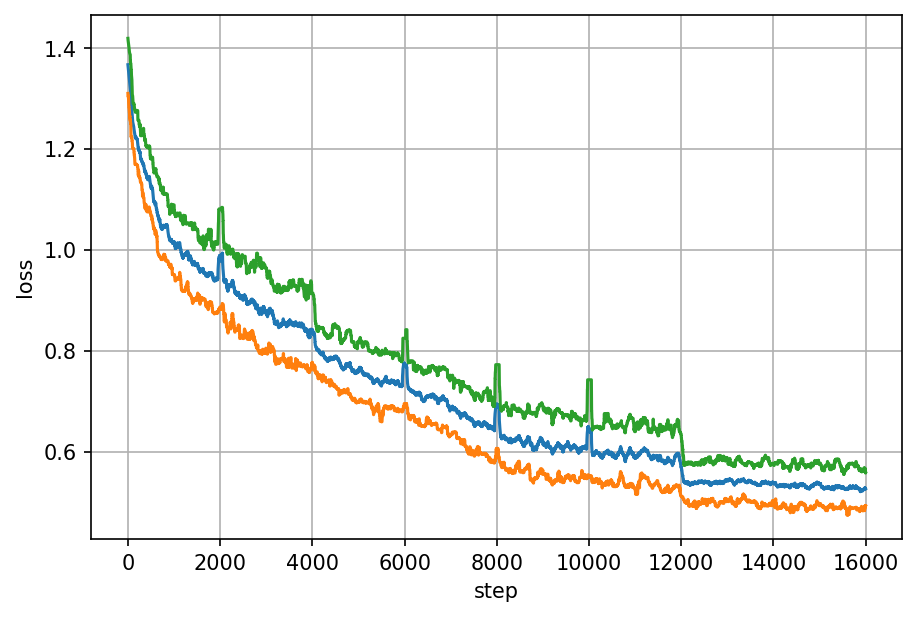

In [18]:
l = pd.Series(losses).rolling(100, center=True, min_periods=0)
plt.plot(l.mean())
plt.plot(l.quantile(0.1))
plt.plot(l.quantile(0.9))
plt.xlabel('step')
plt.ylabel('loss')
plt.grid();

In [19]:
simplesn.nre_losses = losses
simplesn.nre_nets = nre.head, nre.tail

In [20]:
from collections import defaultdict
from clipppy.utils.plotting.nre import MultiNREPlotter


nrep = MultiNREPlotter(
    groups=nre.tail.tails.keys(),
    ranges={**{
        'Om0': (0, 2), 'Ode0': (0, 2),
        'sigma_res': (0., 0.5),
        'sigma_z': (0, 0.2),
        'mean_M0': (-25, -15),
        'alpha': (0, 1),
        'beta': (0, 4)
    }, **nre.dataset.ranges},
    grid_sizes=defaultdict(lambda: 128),
    priors=config.kwargs['defs']['priors'],
    labels={
        'Om0': r'$\Omega_{m, 0}$',
        'Ode0': r'$\Omega_{\Lambda, 0}$',
        'sigma_z': r'$\sigma_z$',
        'sigma_res': r'$\sigma_{\mathrm{res}}$',
        'mean_M0': r'$M_0$',
        'alpha': r'$\alpha$',
        'beta': r'$\beta$'
    }
)

<Figure size 900x600 with 0 Axes>

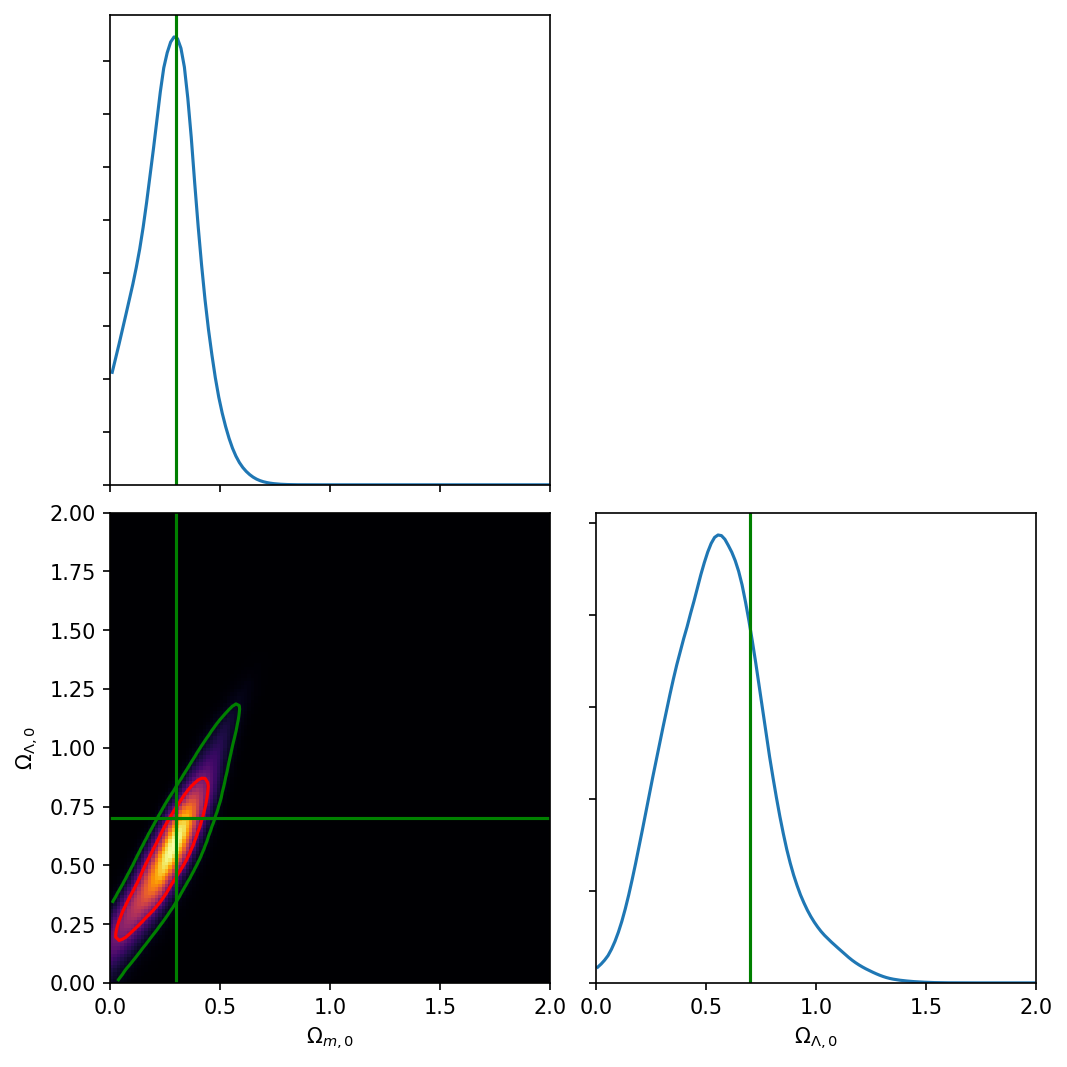

<Figure size 900x600 with 0 Axes>

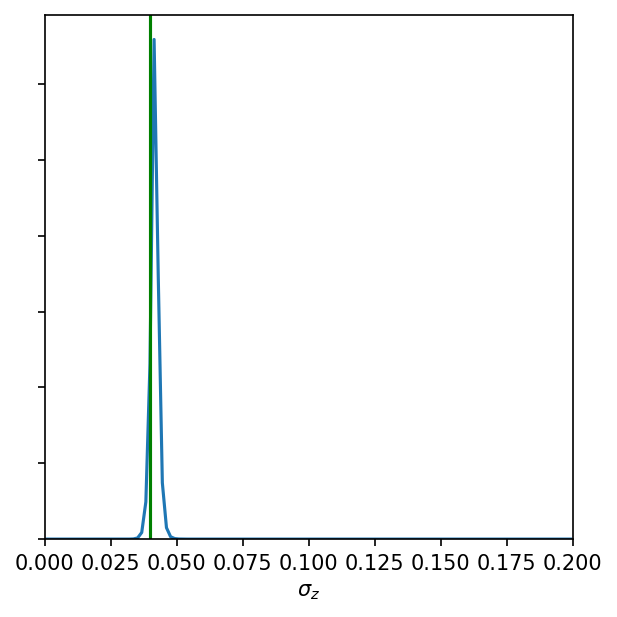

<Figure size 900x600 with 0 Axes>

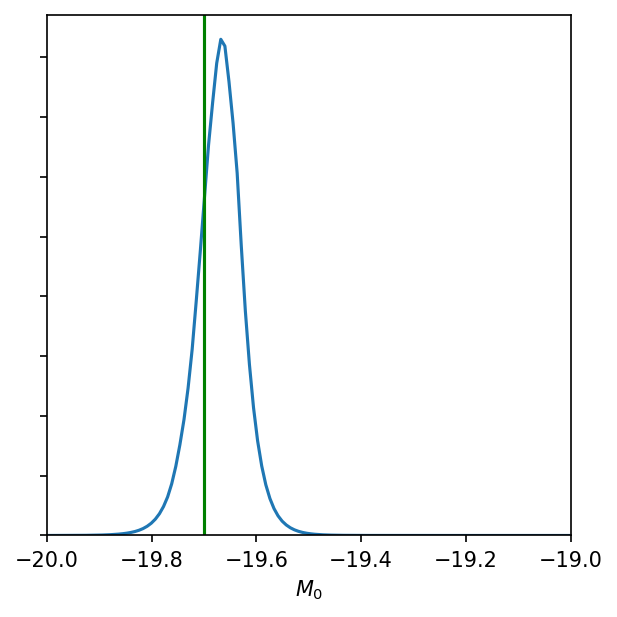

<Figure size 900x600 with 0 Axes>

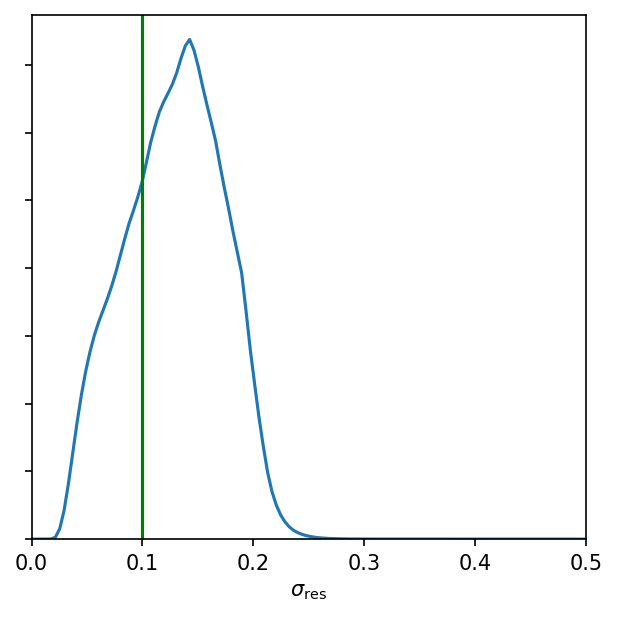

<Figure size 900x600 with 0 Axes>

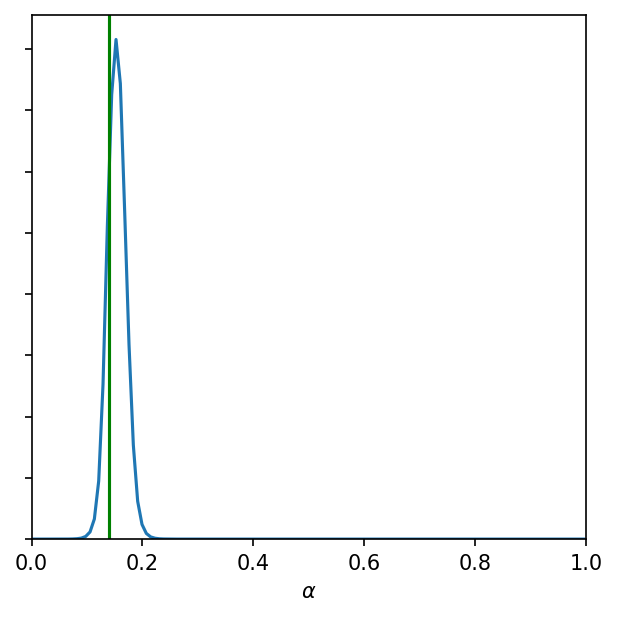

<Figure size 900x600 with 0 Axes>

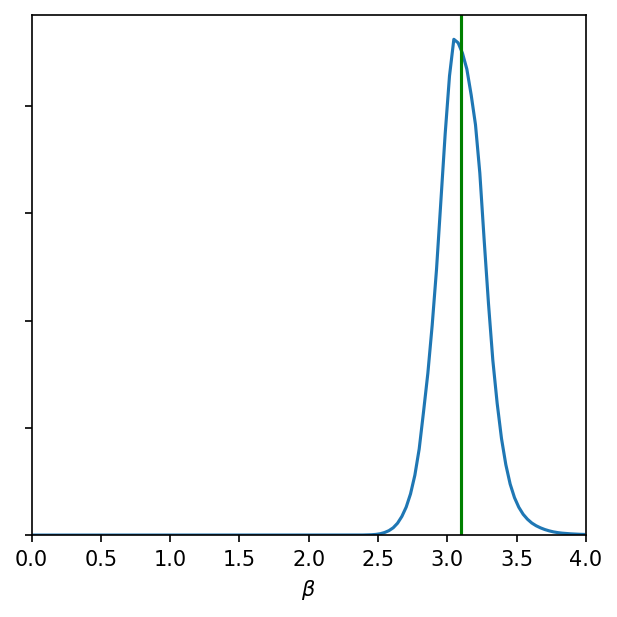

In [29]:
import pyro

data = {
    key: val.detach() if torch.is_tensor(val) else val
    for key, val in pyro.condition(config.mock, data={
        'mean_x1': 0, 'log10_R_x1': 0,
        'mean_c': 0, 'log10_R_c': -1,
        # 'mean_M0': torch.distributions.Uniform(-20., -19.).sample(),
        # 'sigma_res': torch.distributions.Uniform(0, 0.2).sample(),
        'Om0': torch.tensor(0.3), 'Ode0': torch.tensor(0.7),
        'sigma_z': torch.tensor(0.04),
        'mean_M0': torch.tensor(-19.7),
        'sigma_res': torch.tensor(0.1),
        'alpha': torch.tensor(0.14), 'beta': torch.tensor(3.1),
    })(initting=False).nodes.items() for val in [val['value']]
}

obs = {key: data[key].unsqueeze(0) for key in nre.obs_names}

for key in nre.tail.tails.keys():
    plt.figure()
    post = nrep.post_one(key, obs, nre.head, nre.tail)
    nrep.plotters[key].corner(
        post,
        truths={key: float(data[key]) for key in nre.param_names}
    )